In [1]:
# import packages

import numpy as np 
import pandas as pd

import os
import shutil
os.chdir("C:/Users/jonat/OneDrive/Dokumente/1 Uni/2 Master/Semester 1/Higher Level Computer Vision/Project/input/")
print(os.listdir("../input"))

from glob import glob 
from skimage.io import imread
import gc

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

['train', 'train_labels.csv']


Using TensorFlow backend.


# Load training data

In [2]:
base_tile_dir = '../input/train/'
df = pd.DataFrame({'path': glob(os.path.join(base_tile_dir,'*.tif'))})
df['id'] = df.path.map(lambda x: x.split('\\')[1].split(".")[0])
labels = pd.read_csv("../input/train_labels.csv")
df_data = df.merge(labels, on = "id")

# removing this image because it caused a training error previously
df_data = df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data = df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']
df_data.head(3)

,path,id,label
0,../input/train\00001b2b5609af42ab0ab276dd4cd41...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
1,../input/train\000020de2aa6193f4c160e398a8edea...,000020de2aa6193f4c160e398a8edea95b1da598,0
2,../input/train\00004aab08381d25d315384d646f5ce...,00004aab08381d25d315384d646f5ce413ea24b1,0


# Split 80000 training images in 90% train/ 10% test and build folders
# (40000 of each class)

In [3]:
SAMPLE_SIZE = 40000 # load 80k negative and positive examples

# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# filter out class 1
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)

# concat the dataframes
df_data = shuffle(pd.concat([df_0, df_1], axis=0).reset_index(drop=True))

# train_test_split # stratify=y creates a balanced validation set.
y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

# Create directories

# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

# Tranfer the images into the folders

In [4]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])

# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('../input/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('../input/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '../input/test'

# Generate training, validation and test images, add augmentation

In [5]:
from keras.preprocessing.image import ImageDataGenerator

# don't crop images as it works better with the full images
IMAGE_SIZE = 96
num_train_samples = len(df_train)
num_val_samples = len(df_val)

# batch size 32 to not run out of memory
train_batch_size = 32
val_batch_size = 32

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

# Augmentation: Add normalization, random rotation, horizontal and vertical flips
datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                            rotation_range=45,
                            horizontal_flip=True,
                            vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

Found 72000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


# Define the model 

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam

# inspired by VGG-16

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

# model summary
model.summary()

# Compile the model
model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 64)       

# Training

In [46]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10,
                   callbacks=[reducel, earlystopper])

Epoch 1/10
2250/2250 [==============================] - 3153s 1s/step - loss: 0.4638 - accuracy: 0.7885 - val_loss: 0.3246 - val_accuracy: 0.8126
Epoch 2/10
2250/2250 [==============================] - 3121s 1s/step - loss: 0.3978 - accuracy: 0.8258 - val_loss: 0.6819 - val_accuracy: 0.7995

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 3/10
2250/2250 [==============================] - 3079s 1s/step - loss: 0.3421 - accuracy: 0.8555 - val_loss: 0.3440 - val_accuracy: 0.8311

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Restoring model weights from the end of the best epoch
Epoch 00003: early stopping


### Save trained model

In [47]:
# save model
from sklearn.externals import joblib 
joblib.dump(model, 'model.pkl')

['model.pkl']

### Get Training accuracy and loss

In [48]:
# get the metric names so we can use evaulate_generator
model.metrics_names
# Here the best epoch will be used.
val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))
print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.002497727982699871
val_acc: 0.8136249780654907


### Plot training curves

<Figure size 432x288 with 0 Axes>

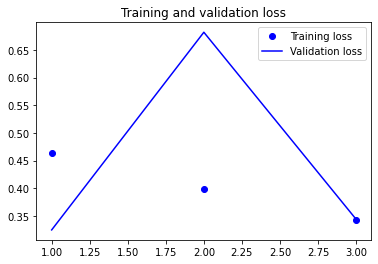

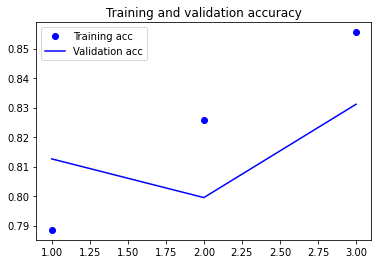

<Figure size 432x288 with 0 Axes>

In [49]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Make a prediction

In [50]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# make a prediction
y_pred_keras = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

8000/8000 [==============================] - 125s 16ms/step


# Evalutation

### ROC Curve

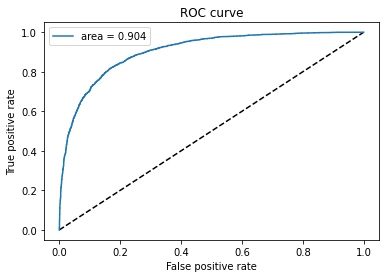

In [51]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.classes, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Output first predictions

In [52]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

# Put the predictions into a dataframe.
df_preds = pd.DataFrame(y_pred_keras, columns=['Confidence Score'])

# Get the true labels
y_true = test_gen.classes

df_preds.head()

,Confidence Score
0,0.063174
1,0.240318
2,0.048480
3,0.449904
4,0.838848


### For the following clculations, round output to 0 or 1 using "y_pred_keras.round()"

### Confusion Matrix

Confusion matrix, without normalization
[[2915 1085]
 [ 428 3572]]


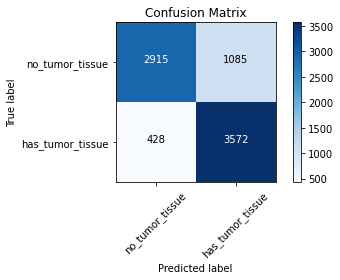

In [53]:
# Create confusion matrix

from sklearn.metrics import confusion_matrix
import itertools

# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Get the labels of the test images.
test_labels = test_gen.classes

# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, y_pred_keras.round())

# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['no_tumor_tissue', 'has_tumor_tissue']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Accuracy

In [56]:
# Accuracy

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true, y_pred_keras.round())
print('The accuracy is {0}.'.format(acc))

The accuracy is 0.810875.


### Classification Report

In [55]:
# Generate a classification report

from sklearn.metrics import classification_report

# For this to work we need y_pred as binary labels not as probabilities
y_true = test_gen.classes
cm_plot_labels = ['Prediction']

report = classification_report(y_true, y_pred_keras.round())

print(report)

              precision    recall  f1-score   support

           0       0.87      0.73      0.79      4000
           1       0.77      0.89      0.83      4000

    accuracy                           0.81      8000
   macro avg       0.82      0.81      0.81      8000
weighted avg       0.82      0.81      0.81      8000

